# ImageJ: Image transforms

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

ImageJ has excellent 2D distance and watershed transforms... although not necessarily everything about them is quite what you might expect.

## Distance transform

````{margin}
```{image} images/imagej-binary-options.png
:width: 75%
````

A 2D distance transform can be calculated in ImageJ using the {menuselection}`Process --> Binary --> Distance Map` command.

A non-obvious feature of this is that the type of output given is determined by the {guilabel}`EDM output` option tucked away under {menuselection}`Process --> Binary --> Options...` (where EDM stands for 'Euclidean Distance Map').
This makes a difference, because the distance between two diagonal pixels is considered $\sqrt{2} \approx 1.414$ (by Pythagoras' theorem) -- which means that a 32-bit output can give more exact straight-line distances without rounding.

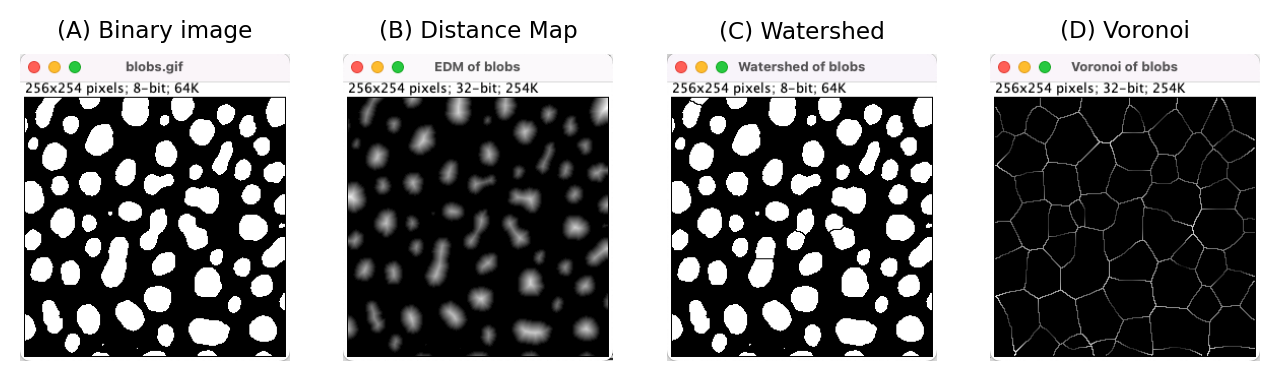

In [2]:
fig = create_figure(figsize=(8, 4))

show_image('images/imagej-blobs-binary.png', title="(A) Binary image", pos=141)
show_image('images/imagej-blobs-distance.png', title="(B) Distance Map", pos=142)
show_image('images/imagej-blobs-watershed.png', title="(C) Watershed", pos=143)
show_image('images/imagej-blobs-voronoi.png', title="(D) Voronoi", pos=144)

glue_fig('fig_distance_commands_imagej', fig)

```{glue:figure} fig_distance_commands_imagej
---
align: center
name: fig-distance_commands_imagej
---

Outputs from several distance transform-related commands in ImageJ.
```

### Ultimate points

{menuselection}`Process --> Binary --> Ultimate Points` is a related command.
It uses the distance transform to identify the last points that would be removed if the objects would be eroded until they disappear.
In other words, it identifies centers.
But these are not simply single center points for each object; rather, they are maximum points in the distance map, and therefore the pixels furthest away from the boundary.

This means that if a structure has several 'bulges', then an ultimate point exists _at the center of each of them_.
If segmentation has resulted in structures being merged together, then each distinct bulge could actually correspond to something interesting -- and the number of bulges actually means more than the number of separated objects in the binary image.

/tmp/ipykernel_3980/1047708357.py:56: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  com = ndimage.measurements.center_of_mass(lab_ultimate, lab_ultimate, index=range(1, n+1))


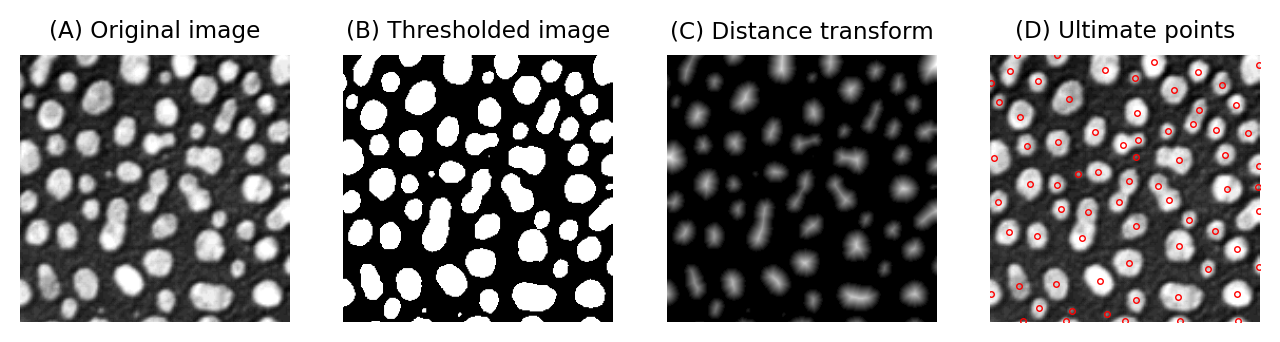

In [3]:
"""
Rather than simply paste screenshots from ImageJ, here I've tried to use
Python/skimage/scipy to replicate the steps taken within ImageJ.

The results aren't guaranteed to be identical, but should be close -
and I hope more useful for learning.
"""

def read_blobs_and_threshold():
    """
    Read the blobs.gif image & convert to binary in a 'standardized' way,
    for consistency across figures.
    """
    # Load & invert blobs (this compensates for the inverted LUT)
    im_blobs = 255 - load_image('blobs.gif')

    # Threshold blobs - we don't need to be sophisticated,
    # almost any half-sensible threshold method should work
    bw_blobs = im_blobs > im_blobs.mean()
    return im_blobs, bw_blobs


def approx_ultimate_points(bw, bw_dist=None):
    """
    Find the ultimate points from a distance map of a binary image.
    These are local maxima that are non-zero in the binary image.

    This *sounds* easy: check where pixel values match the result of applying a maximum filter,
    and those are your maxima.
    However, in practice this can detect lots of spurious peaks / saddle-points.

    ImageJ's 'MaximumFinder' does *a lot* or work, and so generally ImageJ will give a
    reasonable result without the user needing to know what exactly happened.

    To approximate the results here, we can use h-maxima (maxima greater than a fixed threshold)
    with a small dilation to merge maxima that are nearby.

    Much as I'd like to eliminate this step & just use an ImageJ screenshot,
    I've included it to admit the awkwardness of image processing - often methods
    need to be adapted to overcome seemingly minor issues.

    Returns (y, x) tuple of coordinates.
    """
    if bw_dist is None:
        bw_dist = ndimage.distance_transform_edt(bw)

    from skimage.morphology import extrema
    bw_maxima = extrema.h_maxima(bw_dist, 0.5)
    bw_maxima = ndimage.binary_dilation(bw_maxima)
    bw_ultimate = np.bitwise_and(bw, bw_maxima)

    # Reduce all ultimate point regions to a single point
    # (Here, we take the centroids - this wouldn't be robust for weird shapes with holes,
    # but should be ok here)
    lab_ultimate, n = ndimage.label(bw_ultimate)
    com = ndimage.measurements.center_of_mass(lab_ultimate, lab_ultimate, index=range(1, n+1))
    return zip(*com)


# Load images
im_blobs, bw_blobs = read_blobs_and_threshold()

# Create distance transform image
bw_dist = ndimage.distance_transform_edt(bw_blobs)

# Get ultimate points
y, x = approx_ultimate_points(bw_blobs, bw_dist)

# Show results
fig = create_figure(figsize=(8, 4))

show_image(im_blobs, title="(A) Original image", pos=141)
show_image(bw_blobs, title="(B) Thresholded image", pos=142)
show_image(bw_dist, title="(C) Distance transform", pos=143)
show_image(im_blobs, title="(D) Ultimate points", pos=144)
plt.plot(x, y, marker='o', color='r', markersize=2, markeredgewidth=0.5, markerfacecolor='none', linewidth=0)

glue_fig('fig_distance_transform_python', fig)

````{caution}
Although conceptually straightforward, and easy to use in ImageJ, implementing 'Ultimate points' in other software can be tricky.
Here, I've tried to replicate it in Python.
The results aren't necessarily identical to ImageJ's implementation, but should be pretty close.

Select to {guilabel}`Show code cell contents` above to see how it works.

```{glue:figure} fig_distance_transform_python
---
align: center
name: fig-distance_transform_python
---

Computing the ultimate points from a binary image can be an effective step towards counting the objects in the image -- even if these have been merged. It works best when the true objects are round in shape.
```

````

### Watershed (after distance transform)

As the name suggests, ImageJ's {menuselection}`Process --> Binary --> Watershed` command applies a watershed transform.

However, as the name conceals, the watershed transform is always applied to a distance map -- which is calculated automatically in the background.

The clue to this is only that it appears in a {menuselection}`Process --> Binary` submenu, and therefore requires a binary image as input; a 'regular' watershed transform isn't normally applied to a binary image.

Effectively, the seeds of the watershed transform are the 'ultimate points' described above.
The effect of the command is therefore to split 'roundish' objects.

````{margin}
```{image} images/imagej-binary-blobs-stack.png
:width: 75%
````

:::{admonition} Watching the distance transform
:class: tip

If you click the {guilabel}`Dev` toolbar button and select {menuselection}`Debug Mode` from the drop-down menu, then running {menuselection}`Process --> Binary --> Watershed` will generate an image stack that visualizes how the seeds expanded during the watershed processing.

:::

### Voronoi

{menuselection}`Process --> Binary --> Voronoi` is another distance-and-watershed-based command for binary images.

It will partition the image into different regions so that the separation lines have an equal distance to the nearest foreground objects.

````{margin}
```{image} images/imagej-blobs-surroundings.png
:width: 75%
````

````{tab-set}

```{tab-item} Question


Imagine you have created a binary image containing detected cells, but you are only interested in the region inside the cell that is close to the membrane, i.e. within 5 pixels of the edge of each detected object.
Any pixels outside the objects or closer to their centers do not matter.

How would you go about finding these regions using ImageJ and the distance transform?

**Note:** There other ways to do this using techniques we've discussed, although these don't necessarily give identical results.
```


```{tab-item} Answer

This is the approach I was thinking of:
1. Run {menuselection}`Edit --> Invert`
2. Run {menuselection}`Process --> Binary --> Distance Map`
3. Run {menuselection}`Image --> Adjust --> Threshold...`
4. Choose {guilabel}`Set` and enter *Lower Threshold Level: 1* and *Higher Threshold Level: 5*.

There are more possible ways, such as applying a maximum filter and subtracting the original binary image -- but I think the distance transform is more elegant.
The distance transform is also likely to be much faster for large distances, and more precise (assuming you use a 32-bit output).
```

````

## Watershed transform

````{margin}
```{image} images/imagej-find-maxima.png
:width: 75%
````

So if ImageJ has a watershed transform, but it's not the command called {menuselection}`Watershed`, then where is it?

The answer is that it's hidden in the phenomenally useful {menuselection}`Process --> Find maxima` command.

I say 'hidden', because you specifically have to choose the output {guilabel}`Segmented Particles` to use it.
And you'll need to flip your expectations: unlike most watershed transforms, it will start at the *intensity peaks* of the image (i.e. the maxima) and expand outwards, rather than starting at minima.

But don't let those things discourage you: I highly recommend exploring the various options of {menuselection}`Process --> Find maxima` to see what all it can do.
Depending upon which options are selected, this includes finding structures using a global threshold, a local threshold, generating point ROIs and generating binary regions.

:::{admonition} Check out MorphoLibJ
:class: tip

Echoing my recommendation at the end of the last chapter, you should check out **MorphoLibJ** if you would like more transform options -- particularly when it comes to watersheds of various kinds.

See https://imagej.net/plugins/morpholibj for more details.
:::